In [1]:
import sys
!{sys.executable} -m pip install shap

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [2]:
import pandas as pd

import numpy as np
df = pd.read_pickle('data/df.pkl')
df['aspect_min_cos'] = np.cos(np.radians(df['aspect_min']))
df['aspect_min_sin'] = np.sin(np.radians(df['aspect_min']))


df['aspect_max_cos'] = np.cos(np.radians(df['aspect_max']))
df['aspect_max_sin'] = np.sin(np.radians(df['aspect_max']))


df['aspect_mean_cos'] = np.cos(np.radians(df['aspect_mean']))
df['aspect_mean_sin'] = np.sin(np.radians(df['aspect_mean']))
# X = X.drop(columns=['aspect_mean'])

df = df.drop(columns = ['aspect_min', 'aspect_max', 'aspect_mean'])

In [3]:
df.columns

Index(['year', 'plot_id', 'ndvi_peak', 'ndvi_peak_doy', 'ndvi_min',
       'ndvi_integral', 'ndvi_sos', 'ndvi_eos', 'ndvi_los',
       'ndvi_greenup_slope', 'ndvi_senescence_slope', 'key_0', 'slope_mean',
       'slope_min', 'slope_max', 'elev_min', 'elev_max', 'elev_mean',
       'elev_dev_min', 'elev_dev_max', 'elev_dev_mean', 'geometry',
       'total_relief', 'area_m2', 'area_ha', 'ppt_sum', 'ppt_min', 'ppt_max',
       'ppt_avg', 'ppt_var', 'tmean_max', 'tmean_min', 'tmean_avg',
       'tmean_var', 'tmax_max', 'tmax_min', 'tmax_mean', 'tmax_var',
       'tmin_max', 'tmin_min', 'tmin_avg', 'tmin_var', 'vpdmax_mean',
       'vpdmax_max', 'vpdmax_min', 'vpdmax_var', 'vpdmin_mean', 'vpdmin_max',
       'vpdmin_min', 'vpdmin_var', 'frost_days', 'gdd_sum', 'aspect_min_cos',
       'aspect_min_sin', 'aspect_max_cos', 'aspect_max_sin', 'aspect_mean_cos',
       'aspect_mean_sin'],
      dtype='object')

In [4]:
# Example interactions
df['vpdmax_tmax_min'] = df['vpdmax_mean'] * df['tmax_min']
# Slope × aspect components using precomputed sine/cosine
df['slope_x'] = df['slope_mean'] * df['aspect_mean_sin']   # east-west component
df['slope_y'] = df['slope_mean'] * df['aspect_mean_cos']   # north-south component

In [5]:
ndvi_cols = [col for col in df.columns if 'ndvi' in col] + ['year', 'plot_id', 'geometry', 'key_0', 'area_m2']

# ndvi_cols = ndvi_cols.append('year')
# ndvi_cols = ndvi_cols.append('plot_id')


In [6]:
x = df.drop(columns = ndvi_cols, axis = 1)
y = df['ndvi_peak']

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.3, random_state=42)


In [9]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error

model = Ridge(alpha=1.0)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("R2:", r2_score(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))


R2: 0.5088442229988537
RMSE: 0.05667698203426911


In [10]:
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import Pipeline

ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', RidgeCV(alphas=[0.1, 1.0, 10.0], cv=5))
])

ridge_pipeline.fit(X_train, y_train)
print("Best alpha:", ridge_pipeline.named_steps['ridge'].alpha_)
print("Train R^2:", ridge_pipeline.score(X_train, y_train))
print("Test R^2:", ridge_pipeline.score(X_test, y_test))


Best alpha: 1.0
Train R^2: 0.5500419265615406
Test R^2: 0.5090588780978598


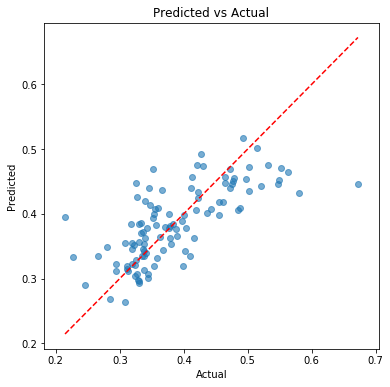

In [11]:
import matplotlib.pyplot as plt

y_pred = ridge_pipeline.predict(X_test)

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual")
plt.show()


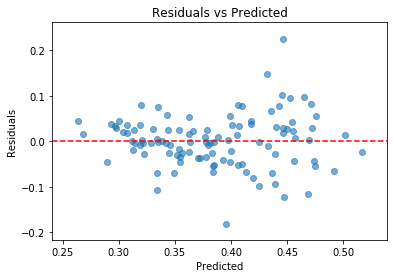

In [12]:
residuals = y_test - y_pred
plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.show()


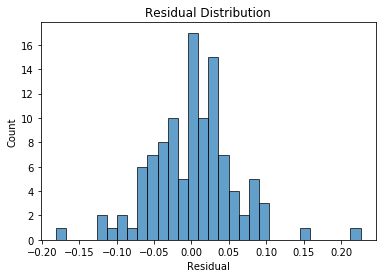

In [13]:
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel("Residual")
plt.ylabel("Count")
plt.title("Residual Distribution")
plt.show()


Top 20 Ridge Features by Importance:
slope_mean         0.049523
slope_x           -0.043800
slope_min         -0.040522
aspect_max_cos    -0.037040
aspect_mean_sin    0.024769
slope_y            0.022278
area_ha            0.021186
total_relief      -0.014502
aspect_min_sin    -0.013586
elev_dev_mean      0.011662
elev_mean          0.011662
tmin_avg           0.009259
gdd_sum            0.007846
aspect_mean_cos    0.006639
tmean_avg          0.006556
ppt_sum            0.006178
ppt_avg            0.006178
elev_max          -0.006070
elev_dev_max      -0.006070
frost_days         0.006013
dtype: float64


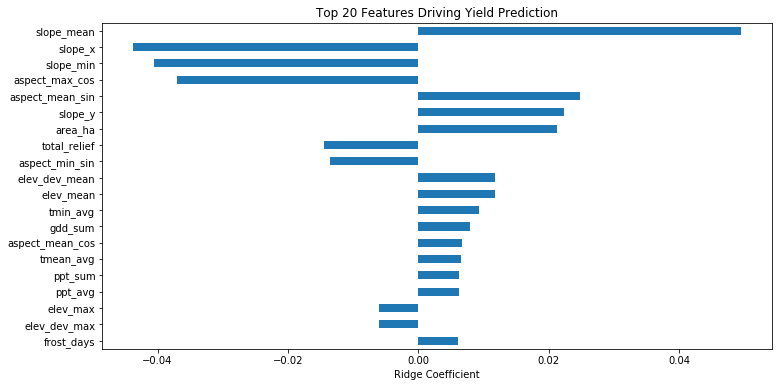

In [14]:
# Extract coefficients from Ridge model
ridge_coef = ridge_pipeline.named_steps['ridge'].coef_

# Map to feature names
feature_importance = pd.Series(ridge_coef, index=x.columns)

# Rank by absolute value
feature_importance_sorted = feature_importance.reindex(feature_importance.abs().sort_values(ascending=False).index)

# Show top 20 features
print("Top 20 Ridge Features by Importance:")
print(feature_importance_sorted.head(20))

# Optional: plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
feature_importance_sorted.head(20).plot(kind='barh')
plt.gca().invert_yaxis()
plt.xlabel("Ridge Coefficient")
plt.title("Top 20 Features Driving Yield Prediction")
plt.show()


In [15]:
# from sklearn.linear_model import LassoCV

# lasso_pipeline = Pipeline([
#     ('scaler', StandardScaler()),
#     ('lasso', LassoCV(alphas=None, cv=5, max_iter=5000))
# ])

# lasso_pipeline.fit(X_train, y_train)
# coef = pd.Series(lasso_pipeline.named_steps['lasso'].coef_, index=x.columns)
# selected_features = coef[coef != 0].index.tolist()

# print("Selected features:", selected_features)


In [16]:
# df['ppt_sum'] = np.log10(df['ppt_sum'])
# df = df.drop('ppt_min', axis = 1)

In [17]:
# # List of skewed features to log-transform
# log_features = ['ppt_sum', 'area_ha', 'vpdmax_mean']

# # Apply log1p (log(1 + x)) to handle zeros
# for f in log_features:
#     df[f + '_log'] = np.log1p(df[f])


In [18]:

# # Clip extreme outliers at 99th percentile
# clip_features = ['vpdmax_mean', 'vpdmin_mean', 'tmax_max']

# for f in clip_features:
#     upper = df[f].quantile(0.99)
#     df[f + '_clip'] = df[f].clip(upper=upper)


In [19]:
from sklearn.model_selection import train_test_split

# Drop target and non-feature columns
features = [c for c in df.columns if c not in [ndvi_cols]]
X = df.drop(columns = ndvi_cols)
y = df['ndvi_peak']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Test R²: 0.7055913693861546
Top 10 Features:
 slope_y            0.145024
vpdmax_mean        0.119440
frost_days         0.087200
area_ha            0.068887
aspect_max_sin     0.059697
slope_min          0.050670
total_relief       0.047680
aspect_mean_cos    0.046619
tmin_min           0.036751
aspect_mean_sin    0.032373
slope_x            0.029508
gdd_sum            0.023315
slope_max          0.022880
tmin_avg           0.022758
elev_min           0.017160
elev_dev_min       0.015885
slope_mean         0.015607
elev_dev_max       0.014126
elev_max           0.014054
elev_dev_mean      0.013735
dtype: float64


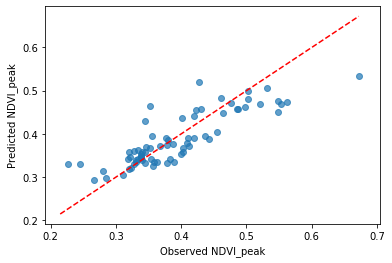

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np

# Prepare features/target
X = df.drop(columns=ndvi_cols)
y = df['ndvi_peak']
# X['vpdmax_mean'].clip(upper=X['vpdmax_mean'].quantile(0.99))
# Simple train/test split (e.g., 80/20 by plots)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
rf = RandomForestRegressor(n_estimators=800, max_depth=12, min_samples_leaf = 2 ,random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

# Metrics
r2 = r2_score(y_test, y_pred)
print("Test R²:", r2)

# Feature importance
feat_imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Top 10 Features:\n", feat_imp.head(20))

# Optional: predicted vs observed plot
plt.figure()
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Observed NDVI_peak")
plt.ylabel("Predicted NDVI_peak")
# plt.title(f"Random Forest Predictions (R²={r2:.2f})")
plt.show()


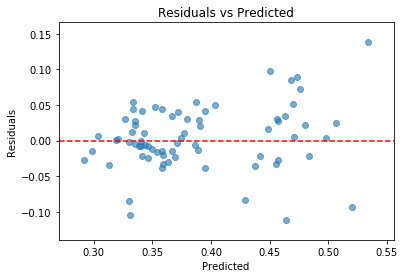

In [21]:
residuals = y_test - y_pred
plt.figure()
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.show()


In [22]:
df

,year,plot_id,ndvi_peak,ndvi_peak_doy,ndvi_min,ndvi_integral,ndvi_sos,ndvi_eos,ndvi_los,ndvi_greenup_slope,...,gdd_sum,aspect_min_cos,aspect_min_sin,aspect_max_cos,aspect_max_sin,aspect_mean_cos,aspect_mean_sin,vpdmax_tmax_min,slope_x,slope_y
0,2017.0,0,0.381850,182,0.196093,60.762067,110.0,300.0,190.0,0.002525,...,1724.653181,-0.154491,0.987994,0.234629,-0.972085,-0.980383,0.197102,284.392823,1.402182,-6.974431
1,2017.0,1,0.379567,184,0.200038,61.954920,90.0,300.0,210.0,0.001910,...,1724.653181,-0.476995,0.878906,-0.770268,-0.637720,-0.983934,0.178534,284.392823,1.277051,-7.038067
2,2017.0,2,0.393801,183,0.197257,67.215369,108.0,300.0,192.0,0.002581,...,1724.653181,-0.810897,0.585189,-0.930432,-0.366465,-0.959642,0.281226,284.392823,3.318337,-11.323332
3,2017.0,3,0.402860,182,0.201931,69.127435,90.0,300.0,210.0,0.002184,...,1724.653181,-0.755880,0.654711,-0.977844,-0.209335,-0.969899,0.243507,284.392823,2.219756,-8.841402
4,2017.0,4,0.371211,187,0.184319,60.787708,133.0,300.0,167.0,0.003149,...,1724.653181,0.210736,0.977543,-0.240438,-0.970665,-0.909309,0.416121,284.392823,2.709197,-5.920146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,2024.0,64,0.330420,178,0.203434,56.748181,90.0,300.0,210.0,0.001443,...,1716.512808,-0.347317,0.937748,-0.104402,-0.994535,-0.999977,0.006717,225.629157,0.037885,-5.639705
356,2024.0,19,0.226620,177,0.115293,36.737290,158.0,219.0,61.0,0.001342,...,1716.512808,0.996998,0.077425,0.984496,-0.175408,-0.999041,0.043774,225.629157,0.385004,-8.786858
357,2024.0,38,0.296172,167,0.184495,51.848044,90.0,276.0,186.0,0.001021,...,1716.512808,0.999998,0.002035,1.000000,-0.000496,-0.413871,0.910336,225.629157,2.606121,-1.184835
358,2024.0,39,0.245004,111,0.122860,36.163359,90.0,152.0,62.0,0.000569,...,1716.512808,1.000000,0.000000,1.000000,-0.000144,-0.822180,-0.569228,225.629157,-1.894515,-2.736394


In [23]:
from patsy import dmatrix
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np

# Example: RF output (top 10 features)
rf_importances = {
    'aspect_mean_cos': 0.291819,
    'vpdmax_mean': 0.238356,
    'aspect_max_sin': 0.063650,
    'area_ha': 0.063054,
    'aspect_mean_sin': 0.040670,
    'elev_dev_min': 0.037540,
    'elev_dev_max': 0.032384,
    'elev_dev_mean': 0.031153,
    'slope_min': 0.030620,
    'slope_mean': 0.025015,
    'slope_max': 0.024911,
    'ppt_max': 0.013761,
    'tmax_min': 0.011215,
    'gdd_sum': 0.009776,
    'tmin_min': 0.009618,
    'aspect_min_sin': 0.008860,
    'tmin_avg': 0.008276,
    'aspect_min_cos': 0.007248,
    'aspect_max_cos': 0.006015,
    'tmean_avg': 0.005967
}

# Decide spline vs linear based on importance threshold
importance_threshold = 0.02  # features above this get splines
spline_cols = [k for k, v in rf_importances.items() if v >= importance_threshold]
linear_cols = [c for c in X.columns if c not in spline_cols]

# Build spline-expanded dataframe
spline_dfs = []
for col in spline_cols:
    # You can adjust df per feature based on importance if you want
    spline_df = dmatrix(f"bs(X['{col}'], df=4, degree=3, include_intercept=False)", 
                        {"X": X}, return_type="dataframe")
    spline_df.columns = [f"{col}_spline{i}" for i in range(spline_df.shape[1])]
    spline_dfs.append(spline_df)

# Combine splines + linear features
X_spline = pd.concat(spline_dfs + [X[linear_cols].reset_index(drop=True)], axis=1)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_spline, y, test_size=0.2, random_state=42)

# Fit Ridge
ridge = Ridge(alpha=0.1)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

# Metrics
r2 = r2_score(y_test, y_pred)
print("Test R²:", r2)

# Feature importance
coef_df = pd.Series(ridge.coef_, index=X_spline.columns)
coef_df = coef_df.reindex(coef_df.abs().sort_values(ascending=False).index)
print("Top 20 features by absolute coefficient:\n", coef_df.head(20))


Test R²: 0.5684957907070842
Top 20 features by absolute coefficient:
 elev_dev_max_spline2       0.214827
elev_dev_max_spline1      -0.206175
slope_mean_spline3         0.170989
elev_dev_min_spline2      -0.166553
area_ha_spline2            0.138660
slope_max_spline2         -0.126113
slope_max_spline3          0.121191
slope_mean_spline4         0.111717
elev_dev_max_spline3      -0.099941
slope_mean_spline1         0.087714
area_ha_spline1           -0.080412
slope_min_spline4         -0.065927
slope_min_spline2         -0.060518
slope_min_spline3         -0.058002
elev_dev_min_spline1      -0.056068
aspect_max_sin_spline3    -0.055161
aspect_mean_sin_spline3    0.053433
slope_mean_spline2         0.053226
aspect_mean_cos_spline1   -0.051764
area_ha_spline3           -0.050041
dtype: float64


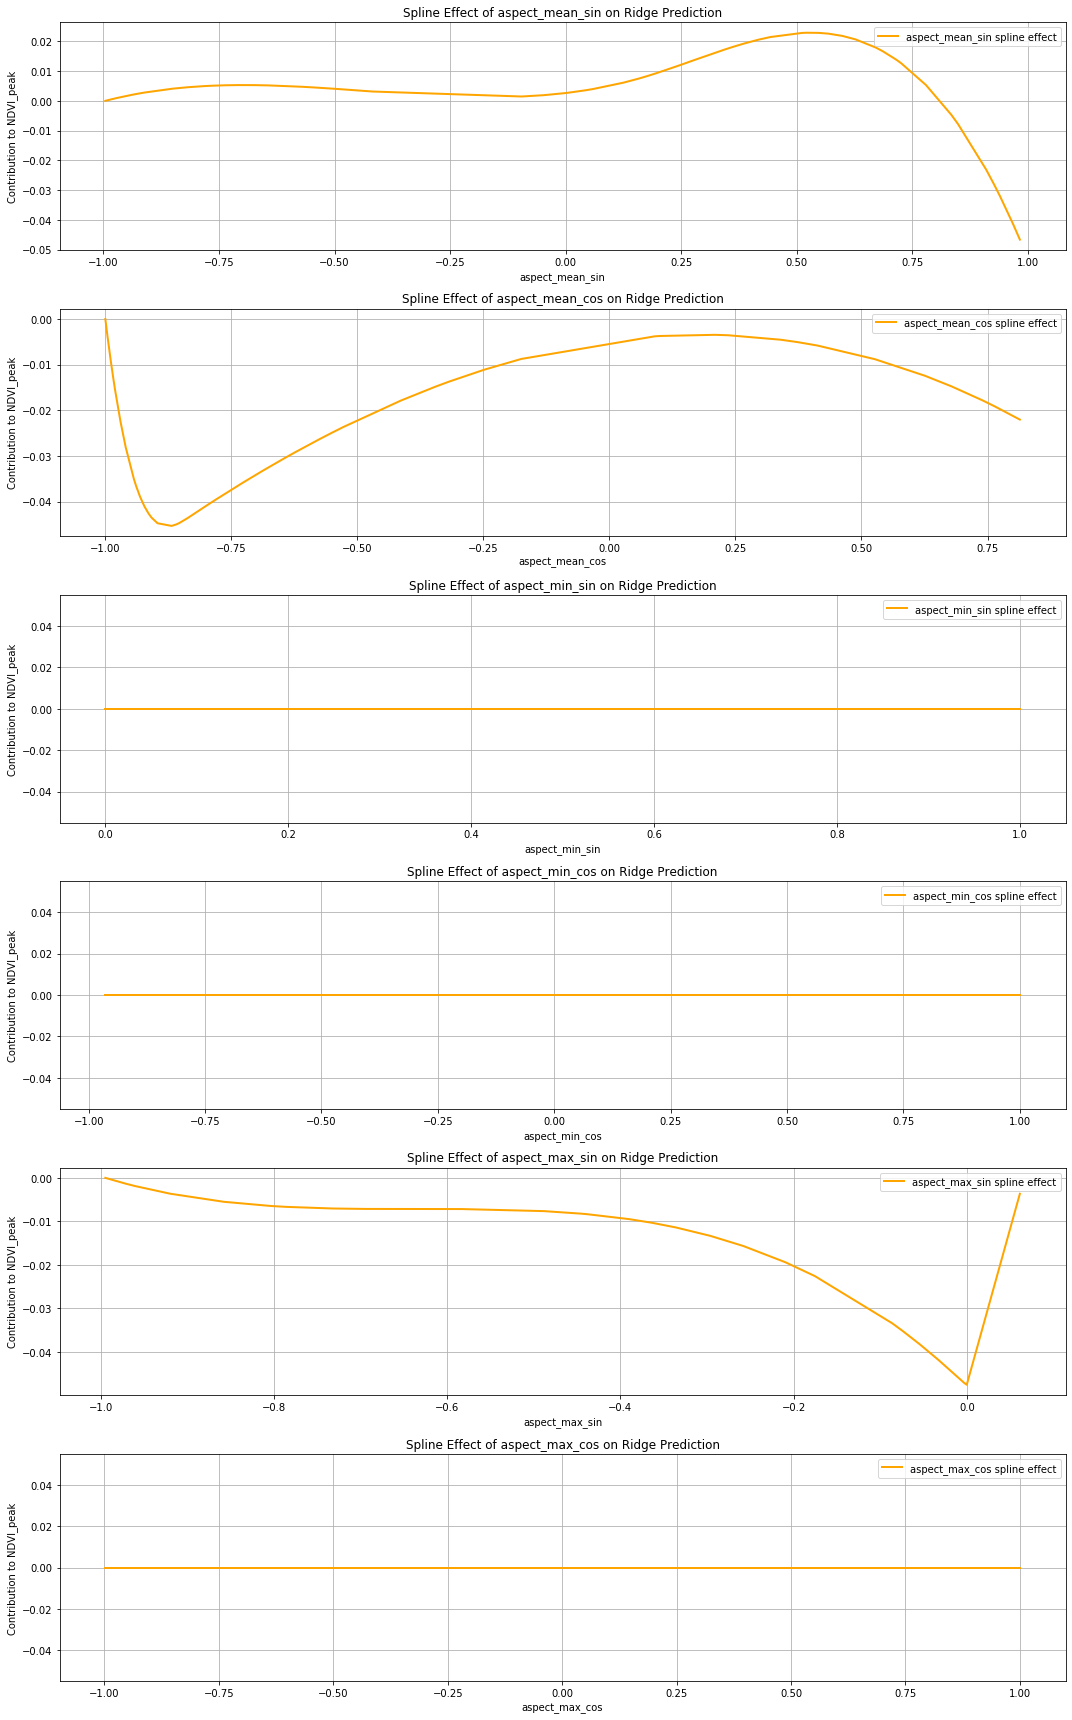

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Top spline features to visualize
top_spline_features = ['aspect_mean_sin', 'aspect_mean_cos', 'aspect_min_sin', 'aspect_min_cos', 'aspect_max_sin','aspect_max_cos']

plt.figure(figsize=(15, 4 * len(top_spline_features)))

for i, feature in enumerate(top_spline_features):
    # Identify spline columns for this feature
    spline_cols = [c for c in X_spline.columns if c.startswith(feature + "_spline")]
    
    # Extract values from training set (X[feature]) for plotting
    x_train_vals = X[feature].values
    sort_idx = np.argsort(x_train_vals)
    
    # Contribution of feature to prediction
    coefs = ridge.coef_[[X_spline.columns.get_loc(c) for c in spline_cols]]
    y_spline = X_spline[spline_cols].values @ coefs
    
    # Plot sorted values vs contribution
    plt.subplot(len(top_spline_features), 1, i + 1)
    plt.plot(x_train_vals[sort_idx], y_spline[sort_idx], color='orange', lw=2, label=f"{feature} spline effect")
    plt.xlabel(feature)
    plt.ylabel("Contribution to NDVI_peak")
    plt.title(f"Spline Effect of {feature} on Ridge Prediction")
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()


In [25]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Pick top spline features to visualize
# top_spline_features = ['elev_dev_min', 'aspect_mean', 'area_ha', 'slope_min']

# plt.figure(figsize=(15, 4 * len(top_spline_features)))

# for i, feature in enumerate(top_spline_features):
#     # Identify all spline columns for this feature
#     spline_cols = [c for c in X_spline.columns if c.startswith(feature + "_spline")]
    
#     # Extract feature values from original X
#     x_vals = X[feature].values
#     sort_idx = np.argsort(x_vals)
    
#     # Coefficients for this feature's splines
#     coefs = ridge.coef_[[X_spline.columns.get_loc(c) for c in spline_cols]]
    
#     # Contribution of the feature
#     y_spline = X_spline[spline_cols].values @ coefs
    
#     # Plot
#     plt.subplot(len(top_spline_features), 1, i + 1)
#     plt.plot(x_vals[sort_idx], y_spline[sort_idx], color='orange', lw=2)
#     plt.xlabel(feature)
#     plt.ylabel("Contribution to NDVI_peak")
#     plt.title(f"Spline effect of {feature}")
#     plt.grid(True)

# plt.tight_layout()
# plt.savefig('spline_curves.png')
# plt.show()


In [26]:
df.columns

Index(['year', 'plot_id', 'ndvi_peak', 'ndvi_peak_doy', 'ndvi_min',
       'ndvi_integral', 'ndvi_sos', 'ndvi_eos', 'ndvi_los',
       'ndvi_greenup_slope', 'ndvi_senescence_slope', 'key_0', 'slope_mean',
       'slope_min', 'slope_max', 'elev_min', 'elev_max', 'elev_mean',
       'elev_dev_min', 'elev_dev_max', 'elev_dev_mean', 'geometry',
       'total_relief', 'area_m2', 'area_ha', 'ppt_sum', 'ppt_min', 'ppt_max',
       'ppt_avg', 'ppt_var', 'tmean_max', 'tmean_min', 'tmean_avg',
       'tmean_var', 'tmax_max', 'tmax_min', 'tmax_mean', 'tmax_var',
       'tmin_max', 'tmin_min', 'tmin_avg', 'tmin_var', 'vpdmax_mean',
       'vpdmax_max', 'vpdmax_min', 'vpdmax_var', 'vpdmin_mean', 'vpdmin_max',
       'vpdmin_min', 'vpdmin_var', 'frost_days', 'gdd_sum', 'aspect_min_cos',
       'aspect_min_sin', 'aspect_max_cos', 'aspect_max_sin', 'aspect_mean_cos',
       'aspect_mean_sin', 'vpdmax_tmax_min', 'slope_x', 'slope_y'],
      dtype='object')

In [27]:
ndvi_cols

['ndvi_peak',
 'ndvi_peak_doy',
 'ndvi_min',
 'ndvi_integral',
 'ndvi_sos',
 'ndvi_eos',
 'ndvi_los',
 'ndvi_greenup_slope',
 'ndvi_senescence_slope',
 'year',
 'plot_id',
 'geometry',
 'key_0',
 'area_m2']

In [47]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Features and target
X = df.drop(columns = ndvi_cols, axis = 1)
y = df['ndvi_integral']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize XGBoost regressor
xgb_model = XGBRegressor(
    n_estimators=1000,      # large number of trees
    learning_rate=0.35,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.6,
    random_state=42
)

# Fit with early stopping
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],  # train and validation sets
    eval_metric="rmse",
    early_stopping_rounds=5,  # stop if no improvement after 50 rounds
    verbose=False
)
# Predict
y_pred = xgb_model.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred)
print("Test R²:", r2)

# Feature importance
importances = xgb_model.feature_importances_
feat_imp = dict(zip(X.columns, importances))
print("Top features:", sorted(feat_imp.items(), key=lambda x: x[1], reverse=True)[:10])


/home/simonhans/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,
/home/simonhans/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


Test R²: 0.8204494608084889
Top features: [('vpdmax_mean', 0.14136906), ('tmean_min', 0.115549035), ('tmin_min', 0.10843855), ('aspect_mean_cos', 0.07449152), ('frost_days', 0.072897606), ('slope_y', 0.045329507), ('slope_min', 0.041519213), ('aspect_max_sin', 0.039261952), ('elev_mean', 0.034344826), ('elev_max', 0.022621978)]


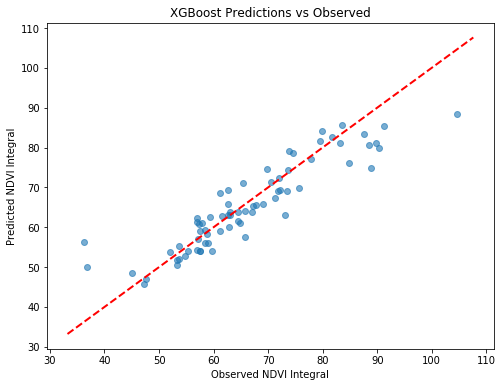

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2)
plt.xlabel("Observed NDVI Integral")
plt.ylabel("Predicted NDVI Integral")
plt.title("XGBoost Predictions vs Observed")
plt.savefig('img/pred_vs_obs.png')
plt.show()


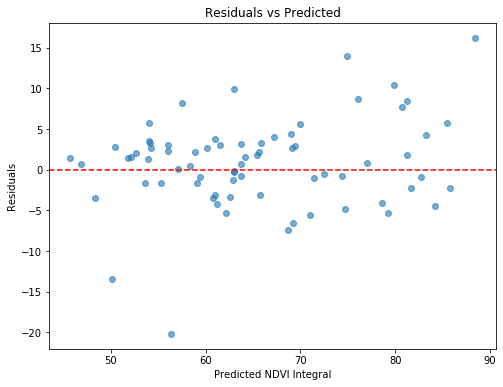

In [58]:
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Predicted NDVI Integral")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.savefig('img/residuals.png')
plt.show()


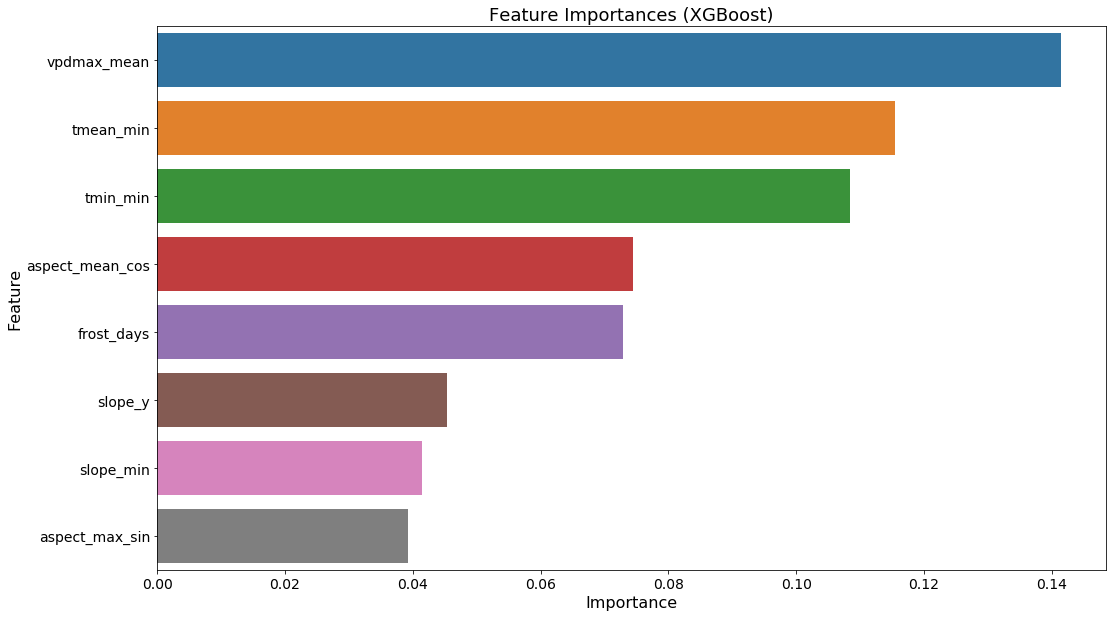

In [57]:
import pandas as pd
import seaborn as sns

feat_imp = pd.DataFrame({
    "feature": X.columns,
    "importance": xgb_model.feature_importances_
}).sort_values("importance", ascending=False)

plt.figure(figsize=(17,10))
sns.barplot(x="importance", y="feature", data=feat_imp.head(8))
plt.title("Feature Importances (XGBoost)", fontsize = 18)
plt.xlabel("Importance", fontsize = 16)
plt.ylabel("Feature", fontsize = 16)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.savefig('img/feature_imp.png')
plt.show()


In [46]:
# import xgboost as xgb

# model = xgb.XGBRegressor(
#     n_estimators=1,
#     max_depth=5,
#     learning_rate=0.05,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     random_state=42
# )

# model.fit(
#     X_train, y_train,
#     eval_set=[(X_train, y_train), (X_test, y_test)],
#     eval_metric='rmse',
#     verbose=False
# )


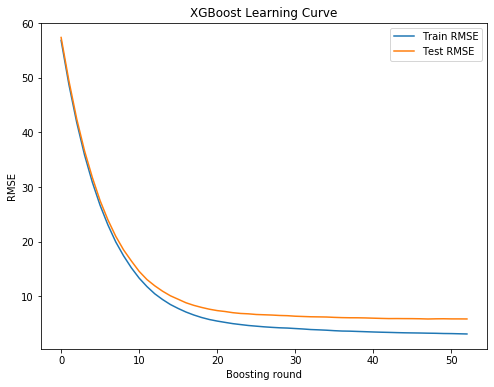

In [33]:
results = xgb_model.evals_result()  # only works for XGBRegressor / xgb.train()
epochs = len(results['validation_0']['rmse'])

import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.plot(range(epochs), results['validation_0']['rmse'], label='Train RMSE')
plt.plot(range(epochs), results['validation_1']['rmse'], label='Test RMSE')
plt.xlabel('Boosting round')
plt.ylabel('RMSE')
plt.title('XGBoost Learning Curve')
plt.legend()
plt.show()


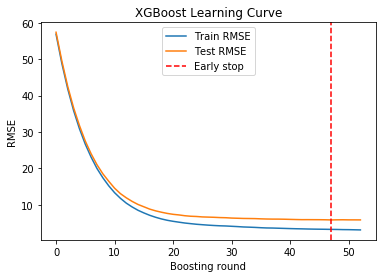

In [34]:
import matplotlib.pyplot as plt

results = xgb_model.evals_result()
plt.plot(results['validation_0']['rmse'], label='Train RMSE')
plt.plot(results['validation_1']['rmse'], label='Test RMSE')
plt.axvline(xgb_model.best_iteration, color='red', linestyle='--', label='Early stop')
plt.xlabel('Boosting round')
plt.ylabel('RMSE')
plt.title('XGBoost Learning Curve')
plt.legend()
plt.show()


In [35]:
# import matplotlib.pyplot as plt
# from sklearn.inspection import PartialDependenceDisplay

# top_features = ['frost_days', 'tmin_avg', 'vpdmax_mean', 'aspect_mean_cos']

# # Loop over features and plot individually
# for feat in X.columns:
#     fig, ax = plt.subplots(figsize=(6, 4))
#     PartialDependenceDisplay.from_estimator(
#         xgb_model,
#         X_test,
#         [feat],
#         kind='both',  # PDP + ICE
#         subsample=100,  # sample for ICE clarity
#         ax=ax
#     )
#     ax.set_title(f'PDP + ICE: {feat}')
#     plt.show()
